## Install the package dependencies before running this notebook

In [2]:
!pip3 install pickle5
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle5 as pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [4]:
from glob import glob
import numpy as np

ROOT_PATH = "/content/drive/MyDrive/UCSD/Classes/CSE 151B/Kaggle Competition/Data/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = np.asarray(pickle.load(open(f_in, "rb")))
#         n = len(inputs)
#         inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = np.asarray(pickle.load(open(f_out, "rb")))
#         outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create dataset for training and testing

In [11]:
train_dataset = ArgoverseDataset(city = 'austin', split = 'train')
train_input = train_dataset.inputs
train_output = train_dataset.outputs
for city in cities:
    train_dataset = ArgoverseDataset(city = city, split = 'train')
    
    if city != 'austin':
        train_input = np.concatenate((train_input, train_dataset.inputs))
        train_output = np.concatenate((train_output, train_dataset.outputs))

# expect (203816, 50, 2), (203816, 60, 2)
print("Total training data:")
print(train_input.shape)
print(train_output.shape)

total_train = np.hstack((train_input, train_output))
train_X = total_train[:,:,0]
train_Y = total_train[:,:,1]
print(train_X.shape)
print(train_Y.shape)

test_dataset = ArgoverseDataset(city = 'austin', split = 'test')
test_input = test_dataset.inputs
for city in cities:
    test_dataset = ArgoverseDataset(city = city, split = 'test')
    
    if city != 'austin':
        test_input = np.concatenate((test_input, test_dataset.inputs))

# expect (29843, 50, 2)
print("Total testing data:")
print(test_input.shape)

test_X = test_input[:,:,0]
test_Y = test_input[:,:,1]
print(test_X.shape)
print(test_Y.shape)

Total training data:
(203816, 50, 2)
(203816, 60, 2)
(203816, 110)
(203816, 110)
Total testing data:
(29843, 50, 2)
(29843, 50)
(29843, 50)


## Training

In [8]:
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

input_X = train_X[:, :50]
output_X = train_X[:, 50:]
input_Y = train_Y[:, :50]
output_Y = train_Y[:, 50:]

models = [None] * 120 # order is x_i, y_i for i < 60

for i in tqdm(range(60)):
    models[2*i] = LinearRegression().fit(input_X, output_X[:, i])
    input_X = np.insert(input_X, 50 + i, output_X[:, i], axis=1)

    models[2*i + 1] = LinearRegression().fit(input_Y, output_Y[:, i])
    input_Y = np.insert(input_Y, 50 + i, output_Y[:, i], axis=1)

  0%|          | 0/60 [00:00<?, ?it/s]

## Testing

In [12]:
for i in tqdm(range(60)):
    pred_X = models[2*i].predict(test_X)
    pred_Y = models[2*i + 1].predict(test_Y)
    test_X = np.insert(test_X, 50 + i, pred_X, axis=1)
    test_Y = np.insert(test_Y, 50 + i, pred_Y, axis=1)

print(test_X.shape)
print(test_Y.shape)

  0%|          | 0/60 [00:00<?, ?it/s]

(29843, 110)
(29843, 110)


## Generate Submission

In [27]:
import pandas as pd

df = pd.read_csv(ROOT_PATH + 'sample_submission.csv')
int_col = df.select_dtypes(include=['int'])
for col in int_col.columns.values:
    df[col] = df[col].astype('float32')

for i in tqdm(range(len(test_X))):
    df.iloc[i, 1:121] = np.ravel(np.vstack((test_X[i, 50:], test_Y[i, 50:])).T)


df.to_csv(ROOT_PATH + 'submission.csv', index=False)

  0%|          | 0/29843 [00:00<?, ?it/s]

## Sample a batch of data and visualize 

39
413896.1825946247
(1, 60, 2)
(60, 2)


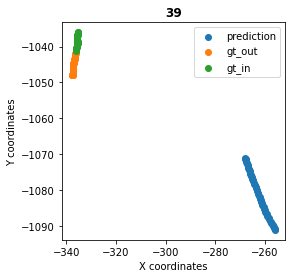

984
28327.25811416954
(1, 60, 2)
(60, 2)


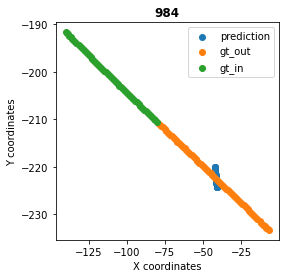

3075
129714.85896842205
(1, 60, 2)
(60, 2)


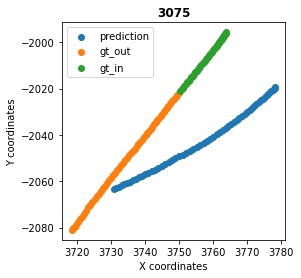

6132
48474.49989137119
(1, 60, 2)
(60, 2)


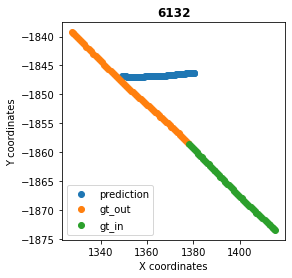

In [ ]:
import matplotlib.pyplot as plt

check = [39, 984, 3075, 6132]

check_dataset = ArgoverseDataset(city = 'austin', split = 'train')
for i in range(len(check_dataset.inputs)):
    if i in check:
        data = torch.from_numpy(check_dataset.inputs[i]).to(device)
        out = check_dataset.outputs[i]
        preds = pred(data).cpu().detach().numpy()
        
        loss = ((preds - out) ** 2).sum()
        print(i)
        print(loss)
        print(preds.shape)
        print(out.shape)
        
        plt.figure(figsize=(4, 4))
        plt.scatter(preds[0, :, 0], preds[0, :, 1], label='prediction')
        plt.scatter(out[:, 0], out[:, 1], label='gt_out')
        plt.scatter(check_dataset.inputs[i][:, 0], check_dataset.inputs[i][:, 1], label='gt_in')
        plt.xlabel('X coordinates')
        plt.ylabel('Y coordinates')
        plt.title(i, fontweight ="bold")
        plt.legend()
        plt.show()